In [23]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [24]:
# Paths to your local dataset
base_dir = 'D:/Rice Leaf Diseases Dataset'

In [25]:
# Image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 16

In [26]:
# Data augmentation with additional techniques
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of data for validation
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 12800 images belonging to 4 classes.
Found 3200 images belonging to 4 classes.


In [27]:
# Compute class weights to handle class imbalance
class_labels = train_generator.class_indices
class_weights = compute_class_weight('balanced', classes=np.arange(len(class_labels)), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

In [28]:
# Load the DenseNet121 model with pre-trained weights, excluding the top layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [29]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Increased dropout rate
predictions = Dense(4, activation='softmax')(x)  # 4 classes

In [30]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [31]:
# Unfreeze more layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])# Unfreeze more layers for fine-tuning

In [32]:
# Implement callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [33]:
# Train the model with more epochs and callbacks
history = model.fit(
    train_generator,
    epochs=20,  # Increased epochs for better training
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop],
    class_weight=class_weights_dict
)

Epoch 1/20
800/800 [==============================] - 409s 482ms/step - loss: 0.2689 - accuracy: 0.9022 - val_loss: 2.1642 - val_accuracy: 0.7297 - lr: 1.0000e-04
Epoch 2/20
800/800 [==============================] - 316s 395ms/step - loss: 0.0911 - accuracy: 0.9697 - val_loss: 2.4056 - val_accuracy: 0.7447 - lr: 1.0000e-04
Epoch 3/20
800/800 [==============================] - 313s 391ms/step - loss: 0.0681 - accuracy: 0.9773 - val_loss: 2.4614 - val_accuracy: 0.7591 - lr: 1.0000e-04
Epoch 4/20
800/800 [==============================] - 314s 392ms/step - loss: 0.0616 - accuracy: 0.9811 - val_loss: 2.4732 - val_accuracy: 0.7319 - lr: 1.0000e-04
Epoch 5/20
800/800 [==============================] - 314s 392ms/step - loss: 0.0423 - accuracy: 0.9862 - val_loss: 2.0762 - val_accuracy: 0.7156 - lr: 1.0000e-04
Epoch 6/20
800/800 [==============================] - 314s 392ms/step - loss: 0.0461 - accuracy: 0.9852 - val_loss: 3.0738 - val_accuracy: 0.7703 - lr: 1.0000e-04
Epoch 7/20
800/800 [==

In [34]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc:.2f}')

200/200 [==============================] - 39s 192ms/step - loss: 2.0156 - accuracy: 0.7675
Validation accuracy: 0.77


In [35]:
# Save the model in the native Keras format
model.save('soyabean_densenet121_model_improved.keras')

In [16]:
!pip install matplotlib seaborn

   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/7.5 MB 2.2 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/7.5 MB 2.1 MB/s eta 0:00:03
   ----------- ---------------------------- 2.1/7.5 MB 2.3 MB/s eta 0:00:03
   ------------- -------------------------- 2.6/7.5 MB 2.5 MB/s eta 0:00:02
   ---------------- ----------------------- 3.1/7.5 MB 2.5 MB/s eta 0:00:02
   ------------------ --------------------- 3.4/7.5 MB 2.3 MB/s eta 0:00:02
   -------------------- ------------------- 3.9/7.5 MB 2.3 MB/s eta 0:00:02
   -------------------------- ------------- 5.0/7.5 MB 2.7 MB/s eta 0:00:01
   -------------------------------- ------- 6.0/7.5 MB 2.9 MB/s eta 0:00:01
   ------------------------------------- -- 7.1/7.5 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 7.5/7.5 MB 3.1 MB/s eta 0:00:00
   -----------------------

In [36]:
# Import necessary libraries for plotting and evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

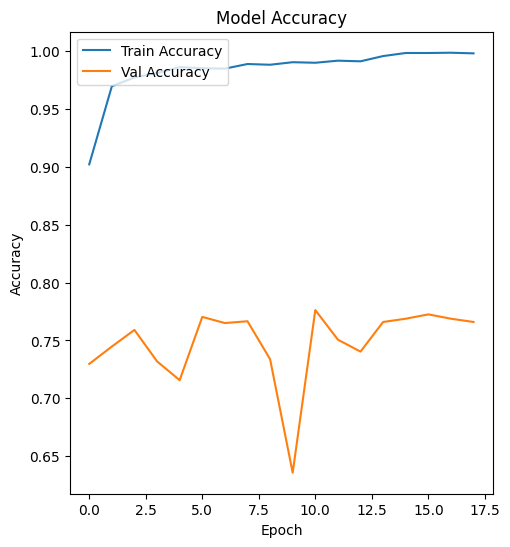

In [38]:
# Assuming 'history' is the result of model.fit()
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

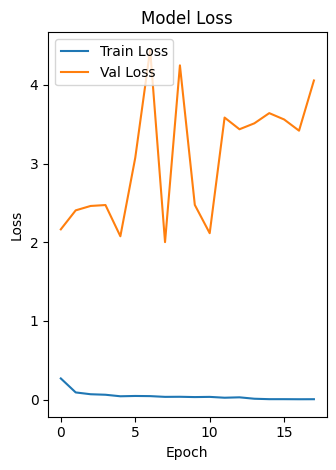

In [40]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

200/200 [==============================] - 39s 190ms/step


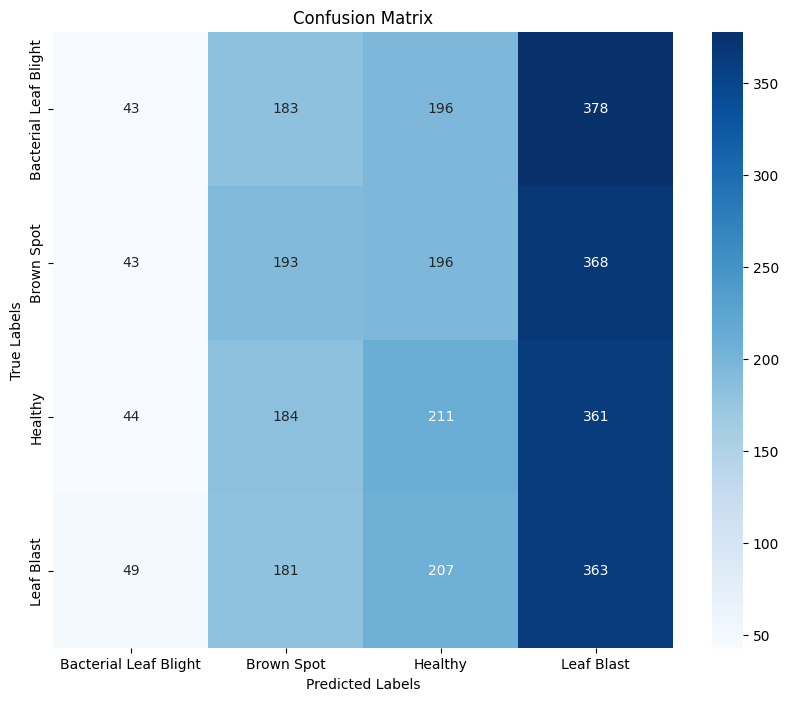

Classification Report:
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.24      0.05      0.09       800
           Brown Spot       0.26      0.24      0.25       800
              Healthy       0.26      0.26      0.26       800
           Leaf Blast       0.25      0.45      0.32       800

             accuracy                           0.25      3200
            macro avg       0.25      0.25      0.23      3200
         weighted avg       0.25      0.25      0.23      3200



In [41]:
# Predict the validation data
val_preds = model.predict(val_generator)
val_preds_classes = np.argmax(val_preds, axis=1)

# Get true labels
val_true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_preds_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Classification report
print('Classification Report:')
print(classification_report(val_true_classes, val_preds_classes, target_names=class_labels))


Checking random images for label: Bacterial Leaf Blight
1/1 [==============================] - 0s 31ms/step
True Label: Bacterial Leaf Blight, Predicted Label: Leaf Blast


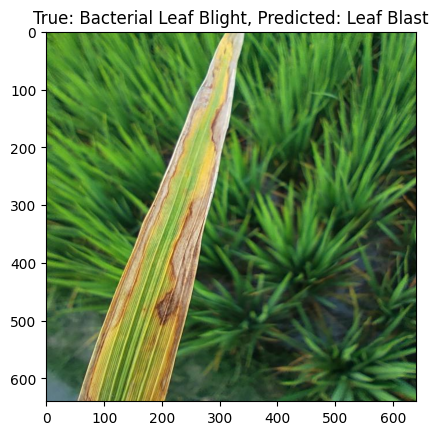

1/1 [==============================] - 0s 27ms/step
True Label: Bacterial Leaf Blight, Predicted Label: Bacterial Leaf Blight


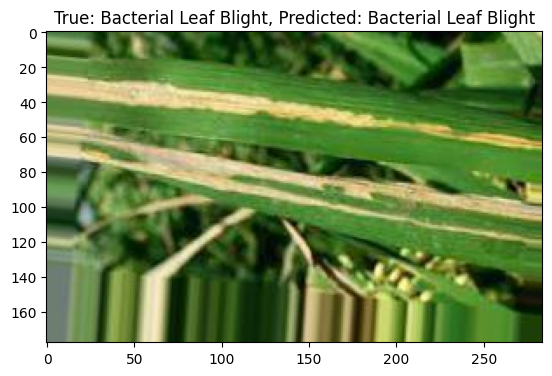

1/1 [==============================] - 0s 23ms/step
True Label: Bacterial Leaf Blight, Predicted Label: Bacterial Leaf Blight


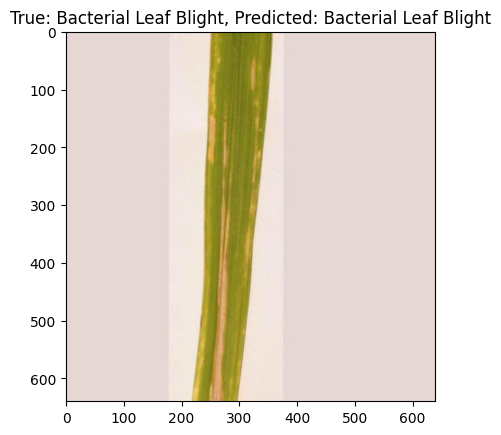

1/1 [==============================] - 0s 26ms/step
True Label: Bacterial Leaf Blight, Predicted Label: Bacterial Leaf Blight


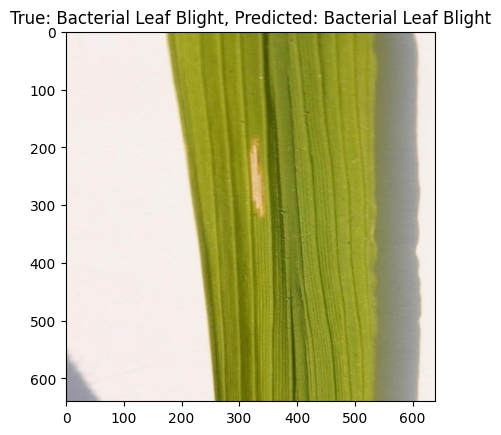

1/1 [==============================] - 0s 25ms/step
True Label: Bacterial Leaf Blight, Predicted Label: Bacterial Leaf Blight


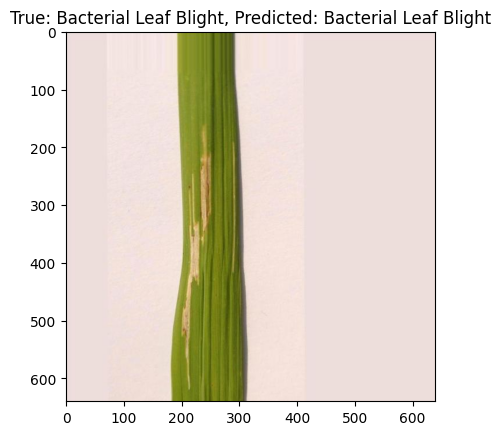

1/1 [==============================] - 0s 23ms/step
True Label: Bacterial Leaf Blight, Predicted Label: Leaf Blast


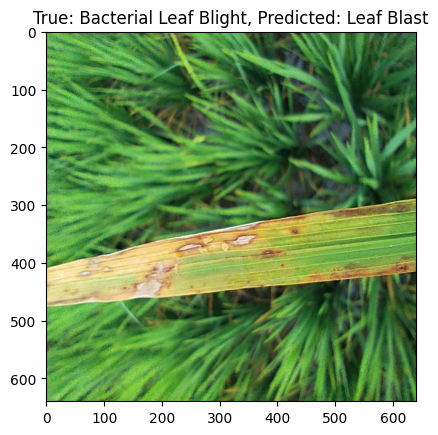

1/1 [==============================] - 0s 25ms/step
True Label: Bacterial Leaf Blight, Predicted Label: Bacterial Leaf Blight


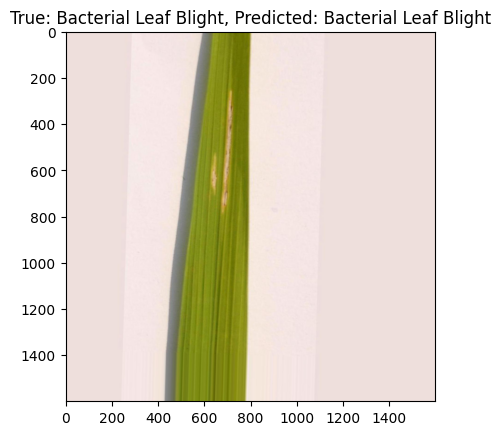

1/1 [==============================] - 0s 23ms/step
True Label: Bacterial Leaf Blight, Predicted Label: Bacterial Leaf Blight


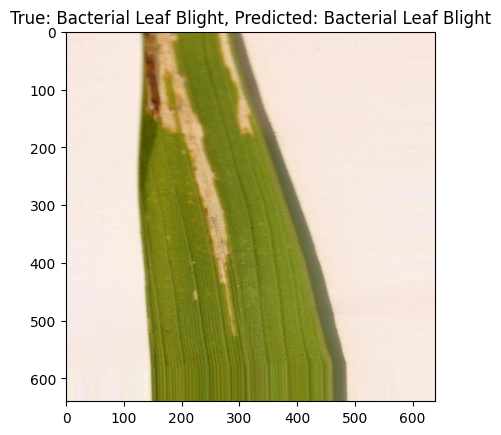

1/1 [==============================] - 0s 25ms/step
True Label: Bacterial Leaf Blight, Predicted Label: Bacterial Leaf Blight


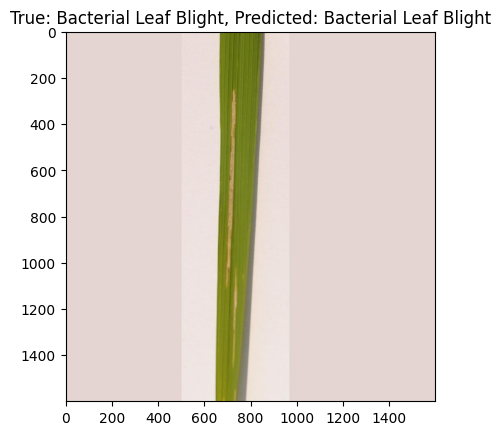

1/1 [==============================] - 0s 23ms/step
True Label: Bacterial Leaf Blight, Predicted Label: Bacterial Leaf Blight


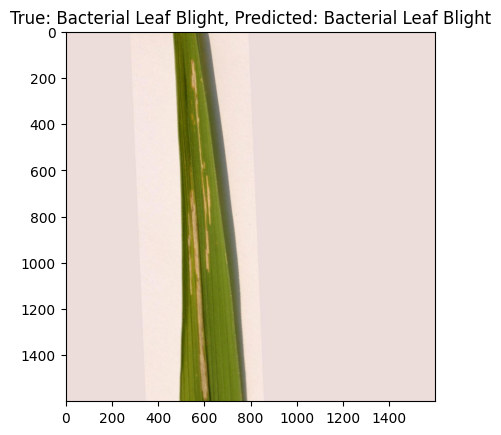


Checking random images for label: Brown Spot
1/1 [==============================] - 0s 24ms/step
True Label: Brown Spot, Predicted Label: Brown Spot


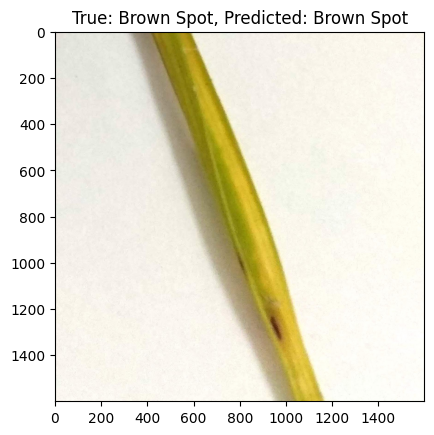

1/1 [==============================] - 0s 23ms/step
True Label: Brown Spot, Predicted Label: Brown Spot


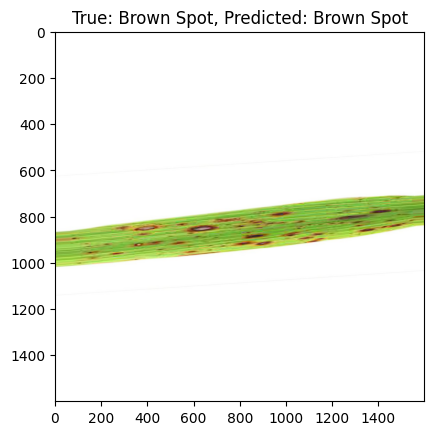

1/1 [==============================] - 0s 25ms/step
True Label: Brown Spot, Predicted Label: Brown Spot


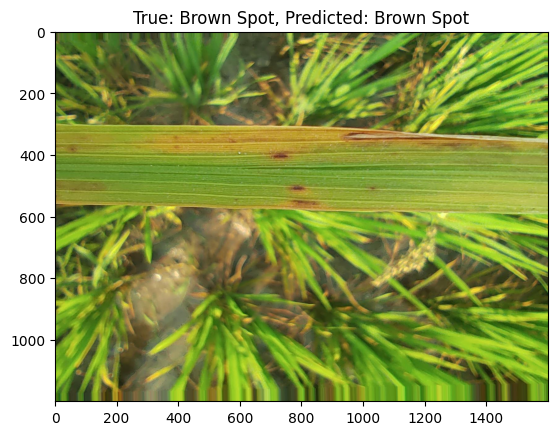

1/1 [==============================] - 0s 24ms/step
True Label: Brown Spot, Predicted Label: Brown Spot


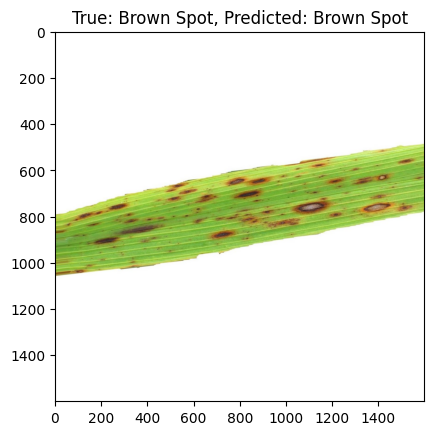

1/1 [==============================] - 0s 23ms/step
True Label: Brown Spot, Predicted Label: Leaf Blast


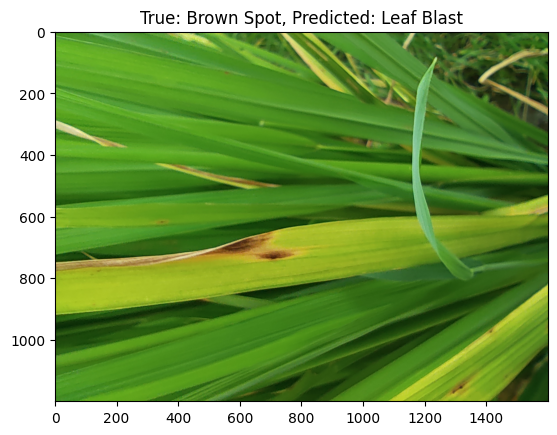

1/1 [==============================] - 0s 24ms/step
True Label: Brown Spot, Predicted Label: Brown Spot


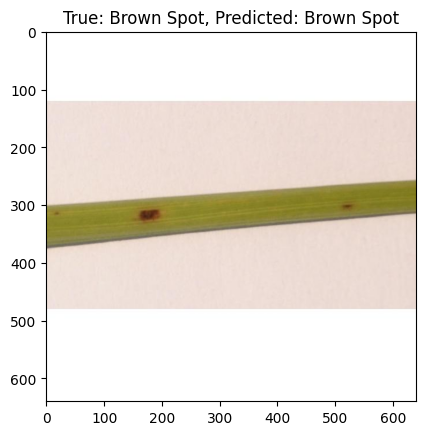

1/1 [==============================] - 0s 25ms/step
True Label: Brown Spot, Predicted Label: Brown Spot


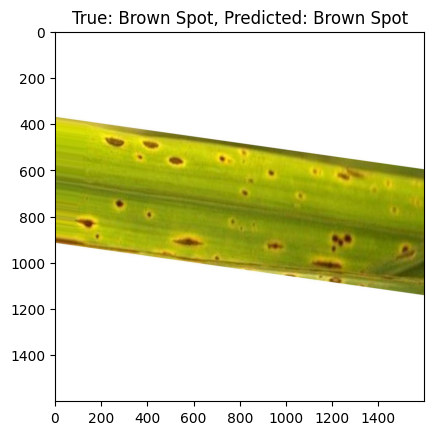

1/1 [==============================] - 0s 28ms/step
True Label: Brown Spot, Predicted Label: Brown Spot


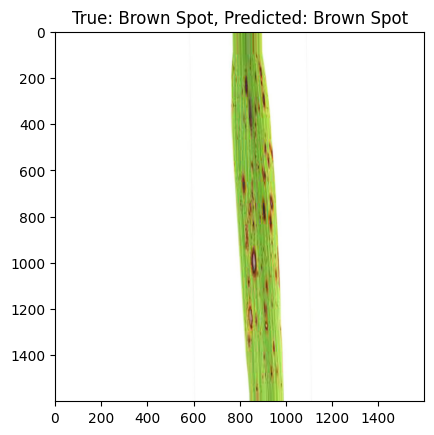

1/1 [==============================] - 0s 26ms/step
True Label: Brown Spot, Predicted Label: Brown Spot


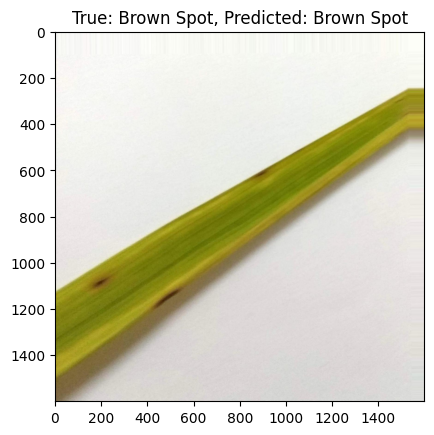

1/1 [==============================] - 0s 23ms/step
True Label: Brown Spot, Predicted Label: Brown Spot


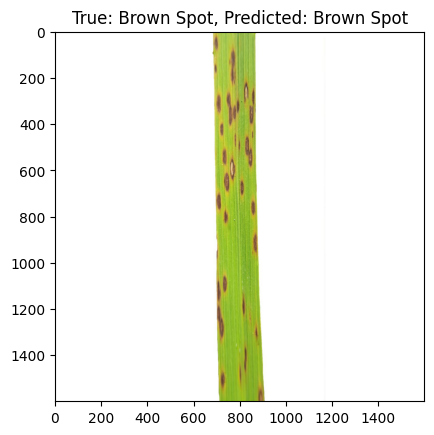


Checking random images for label: Healthy
1/1 [==============================] - 0s 22ms/step
True Label: Healthy, Predicted Label: Healthy


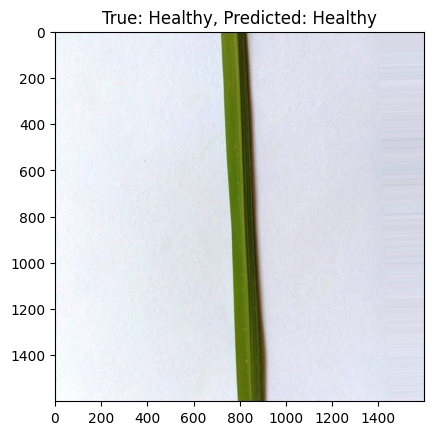

1/1 [==============================] - 0s 23ms/step
True Label: Healthy, Predicted Label: Healthy


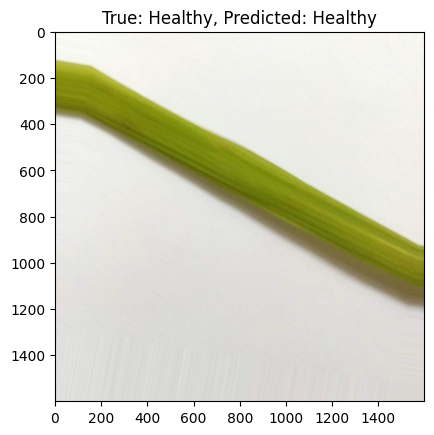

1/1 [==============================] - 0s 26ms/step
True Label: Healthy, Predicted Label: Healthy


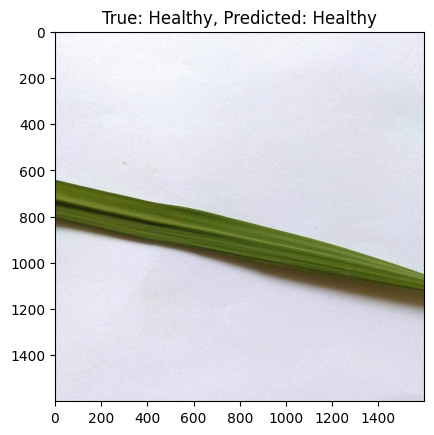

1/1 [==============================] - 0s 26ms/step
True Label: Healthy, Predicted Label: Healthy


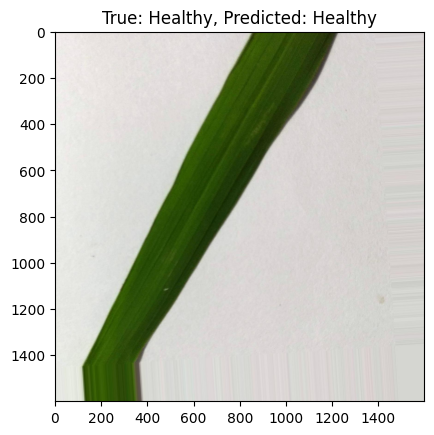

1/1 [==============================] - 0s 29ms/step
True Label: Healthy, Predicted Label: Healthy


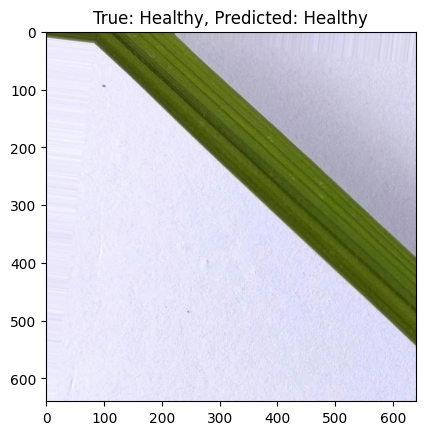

1/1 [==============================] - 0s 26ms/step
True Label: Healthy, Predicted Label: Healthy


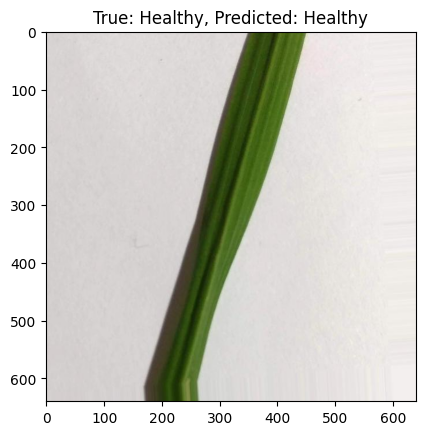

1/1 [==============================] - 0s 24ms/step
True Label: Healthy, Predicted Label: Healthy


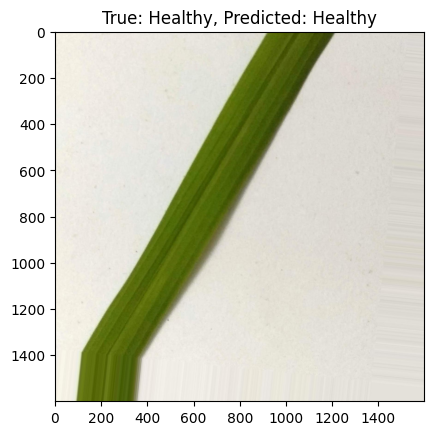

1/1 [==============================] - 0s 27ms/step
True Label: Healthy, Predicted Label: Healthy


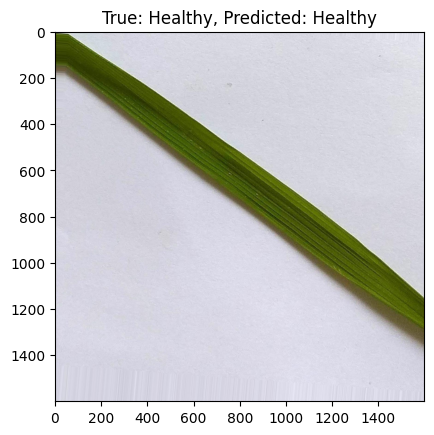

1/1 [==============================] - 0s 25ms/step
True Label: Healthy, Predicted Label: Healthy


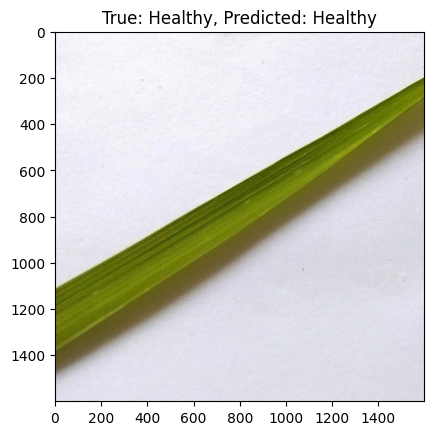

1/1 [==============================] - 0s 25ms/step
True Label: Healthy, Predicted Label: Healthy


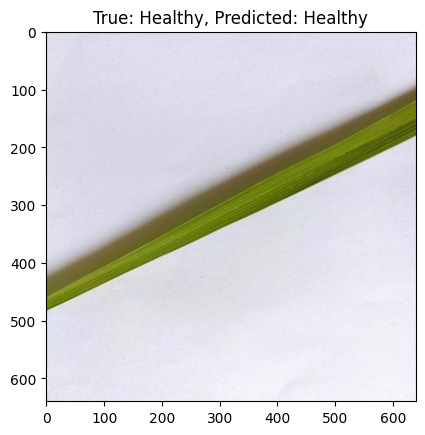


Checking random images for label: Leaf Blast
1/1 [==============================] - 0s 25ms/step
True Label: Leaf Blast, Predicted Label: Leaf Blast


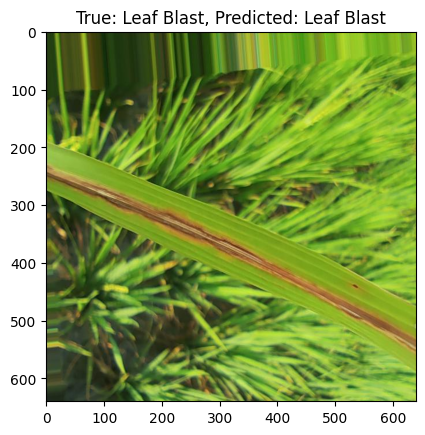

1/1 [==============================] - 0s 24ms/step
True Label: Leaf Blast, Predicted Label: Leaf Blast


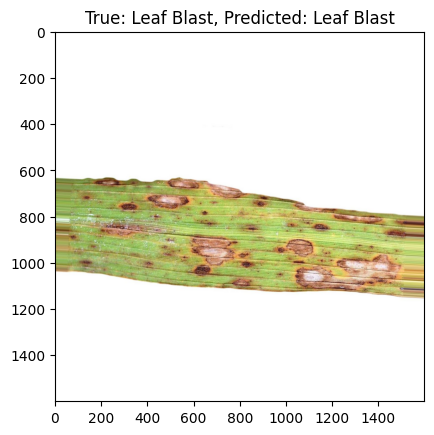

1/1 [==============================] - 0s 24ms/step
True Label: Leaf Blast, Predicted Label: Leaf Blast


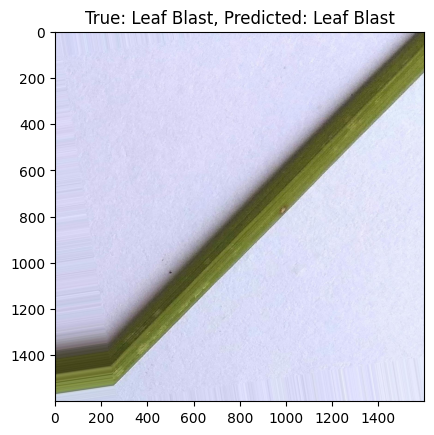

1/1 [==============================] - 0s 25ms/step
True Label: Leaf Blast, Predicted Label: Leaf Blast


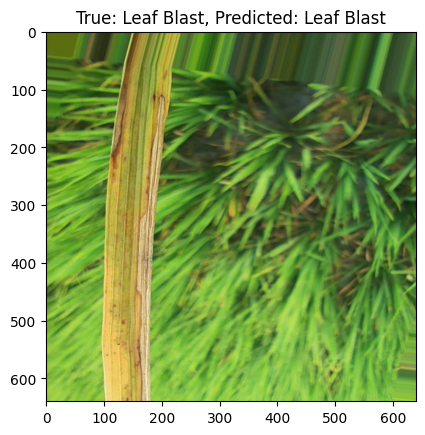

1/1 [==============================] - 0s 26ms/step
True Label: Leaf Blast, Predicted Label: Leaf Blast


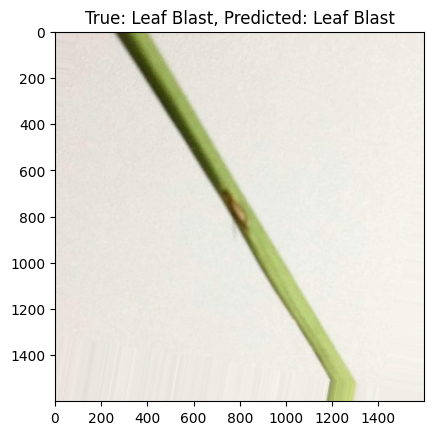

1/1 [==============================] - 0s 37ms/step
True Label: Leaf Blast, Predicted Label: Leaf Blast


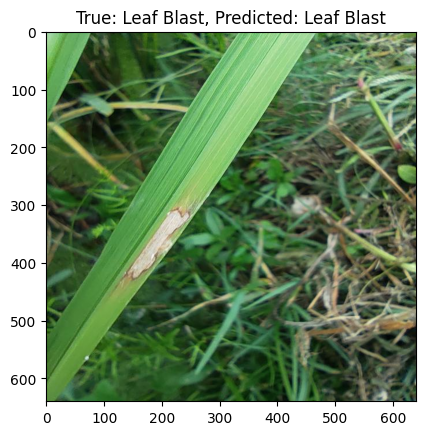

1/1 [==============================] - 0s 32ms/step
True Label: Leaf Blast, Predicted Label: Leaf Blast


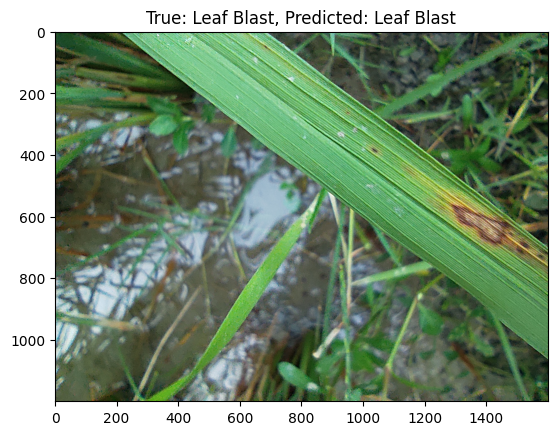

1/1 [==============================] - 0s 23ms/step
True Label: Leaf Blast, Predicted Label: Leaf Blast


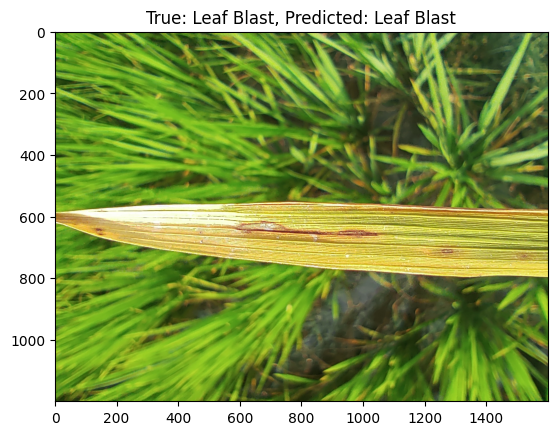

1/1 [==============================] - 0s 23ms/step
True Label: Leaf Blast, Predicted Label: Leaf Blast


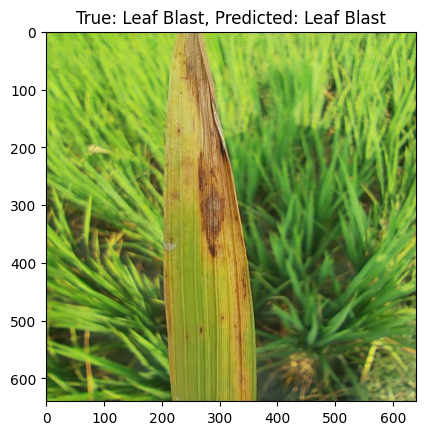

1/1 [==============================] - 0s 27ms/step
True Label: Leaf Blast, Predicted Label: Leaf Blast


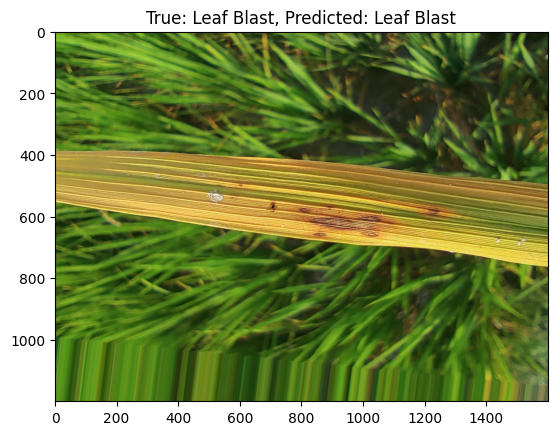

In [45]:
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define the class labels (these should match your dataset)
class_labels = train_generator.class_indices
label_map = {v: k for k, v in class_labels.items()}  # Invert the mapping to get the class names by index

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, img_height=224, img_width=224):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale to [0, 1] range
    return img_array

# Randomly select 10 images from each class
random_images = {}
num_samples_per_label = 10  # Number of random images per label

for label in class_labels:
    label_dir = os.path.join(base_dir, label)  # Path to the folder of each label
    image_files = os.listdir(label_dir)
    random_images[label] = random.sample(image_files, num_samples_per_label)  # Randomly select 10 images

# Load and predict the label for each random image
for label, image_list in random_images.items():
    print(f"\nChecking random images for label: {label}")
    
    for img_file in image_list:
        img_path = os.path.join(base_dir, label, img_file)
        img_array = load_and_preprocess_image(img_path)
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]
        predicted_label = label_map[predicted_class]
        
        print(f"True Label: {label}, Predicted Label: {predicted_label}")
        
        # Optionally display the image and prediction
        img = image.load_img(img_path)
        plt.imshow(img)
        plt.title(f"True: {label}, Predicted: {predicted_label}")
        plt.show()
